In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


2023-08-17 13:12:16.060300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 13:12:16.743821: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-17 13:12:16.743864: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-17 13:12:19.802374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [10]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [11]:
filenames=os.listdir("archive-old/dogs_vs_cats/train/")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})
df

,filename,category
0,cat.11253.jpg,0
1,dog.8030.jpg,1
2,cat.1374.jpg,0
3,cat.7344.jpg,0
4,cat.9172.jpg,0
...,...,...
19997,dog.9075.jpg,1
19998,cat.9188.jpg,0
19999,cat.1111.jpg,0
20000,dog.4822.jpg,1


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [16]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [17]:
train_datagen = ImageDataGenerator(rotation_range=15,
                    rescale=1./255,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1
                    )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                     "archive-old/dogs_vs_cats/train/",x_col='filename',y_col='category',
                                     target_size=Image_Size,
                                     class_mode='categorical',
                                     batch_size=batch_size)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
validate_df, 
"archive-old/dogs_vs_cats/train/", 
x_col='filename',
y_col='category',
target_size=Image_Size,
class_mode='categorical',
batch_size=batch_size
)
test_datagen = ImageDataGenerator(rotation_range=15,
                    rescale=1./255,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1)
test_generator = train_datagen.flow_from_dataframe(train_df,
                                     "archive-old/dogs_vs_cats/test/",x_col='filename',y_col='category',
                                     target_size=Image_Size,
                                     class_mode='categorical',
                                     batch_size=batch_size)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


/home/amangoel/anaconda3/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/home/amangoel/anaconda3/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames belonging to 0 classes.


/home/amangoel/anaconda3/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 16001 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [19]:
epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1066/1066 [==============================] - 448s 420ms/step - loss: 0.7191 - accuracy: 0.6306 - val_loss: 0.6371 - val_accuracy: 0.6358 - lr: 0.0010
Epoch 2/10
1066/1066 [==============================] - 385s 361ms/step - loss: 0.5683 - accuracy: 0.7102 - val_loss: 0.6684 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 3/10
1066/1066 [==============================] - 361s 339ms/step - loss: 0.5225 - accuracy: 0.7436 - val_loss: 0.5949 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 4/10
1066/1066 [==============================] - 428s 401ms/step - loss: 0.4859 - accuracy: 0.7661 - val_loss: 0.4366 - val_accuracy: 0.8075 - lr: 0.0010
Epoch 5/10
1066/1066 [==============================] - 421s 395ms/step - loss: 0.4589 - accuracy: 0.7853 - val_loss: 0.4698 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 6/10
1066/1066 [==============================] - 423s 397ms/step - loss: 0.4349 - accuracy: 0.8017 - val_loss: 0.6237 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 7/10
1066/1066 [============

1/1 [==============================] - 0s 28ms/step
[0]
[[0.89497733 0.10502264]]


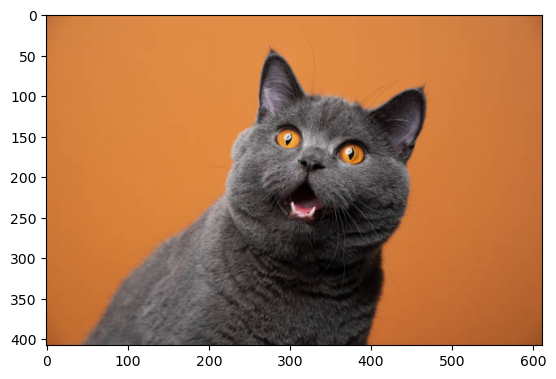

In [34]:
results={
    0:'cat',
    1:'dog'
}

from PIL import Image
import numpy as np
im=Image.open("istockphoto-1361394182-612x612.jpg")
plt.imshow(im)
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255

pred=model.predict(im)
print(np.argmax(pred, axis=1))

print(pred)

In [36]:
from tensorflow.keras.models import load_model
model.save('image_classification.h5')